$\LaTeX \text{ commands here}
\newcommand{\R}{\mathbb{R}}
\newcommand{\im}{\text{im}\,}
\newcommand{\norm}[1]{||#1||}
\newcommand{\inner}[1]{\langle #1 \rangle}
\newcommand{\span}{\mathrm{span}}
\newcommand{\proj}{\mathrm{proj}}
\newcommand{\OPT}{\mathrm{OPT}}
\newcommand{\vx}{\vec{x}}
\newcommand{\I}{\mathbb{I}}
$


<hr style="border: 5px solid black">

**Georgia Tech, CS 4540**

# Lecture 23: Sampling and Markov Chains

Jacob Abernethy

*Date:  Thursday, November 21, 2019*

## A Core CS Problem: Sampling from a Distrbution

There are many problems on which we need to be able to generate random samples from various probability distributions. 

- **Cryptography**: Generate random prime numbers
- **Optimization**: Optimizing non-convex functions using *simulated annealing*
- **Physics**: Sample states of a physical system, i.e. the spin direction of particles in a solid
- **Machine Learning**: Sample parameters from the posterior distribution of a Bayesian model

## Sampling has had a rebirth in ML

We have recently seen the birth of Generative Adversarial Networks, a deep learning technique for producing random samples that appear to resemble images that match the distribution of some training set.

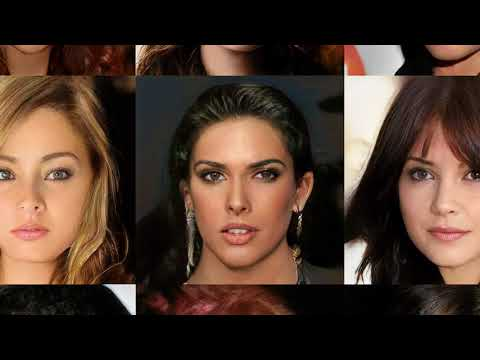

In [3]:
from IPython.display import YouTubeVideo
YouTubeVideo('XOxxPcy5Gr4')


## Algorithms for sampling simple probability distributions

Let's say I have the ability to sample a fair coin toss $X \in \{0,1\}$ as many times as I want (equal probability of 0 and 1).

#### Problem

1. Using my access to coin tosses, how can I sample a real-valued random variable $U$ that is uniformly distributed on $[0,1]$? Assume I have to output this to $k$ values of precision.
1. Using coin tosses, how can I sample a discrete random variable $Z$ from $[n]$ that has distribution $P(Z = i) = p_i$, $i=1, \ldots, n$? 

## More sampling

Let's try a bigger class of distributions.

#### Problem

1. How can I sample a random variable $Z$ from the standard *exponential distribution*? A standard exponential has PDF $p(Z = x) = \exp(-x)$ and CDF $P(Z \leq x) = 1 - \exp(-x)$. (*Hint*: can you somehow transform a random variable $U$ that is uniform on $[0,1]$ into an exponential distribution?)
1. Take any distribution with CDF $f(x) = P(Z \leq x)$. Assume we can invert $f$, so for any $p \in (0,1)$ we can find $f^{-1}(p)$. How can we sample from this distribution using only coin tosses?

## Sampling can get very tricky

Here are some canonical examples of tricky (and sometimes #P-hard!) sampling problems:

1. Sampling a random spanning tree in a graph (this is possible!)
1. Sampling a random cycle in a graph (not easy)
1. Sampling a random Euler cyle in a graph (not easy)
1. Sampling a random perfect matching in a graph (we have good approximate method here!)

## The permanent of a matrix, and perfect matchings

Assume we have an $n \times n$ binary matrix $M$. Recall that the *permanent* of a matrix is defined as
$$\text{perm}(M) = \sum_{\sigma \in S_n} \prod_{i=1}^n M_{i\sigma(i)}$$
where $S_n$ is the set of all $n!$ permutations. 

**Note**: Computing the determinant of a matrix is easy! But computing the permanent is #P-hard!!!

#### Problem

Convince yourself that computing the permanent of binary matrix $M$ is equivalent to counting the number of perfect matchings in an undirected bipartite graph with $n$ nodes in each partition.

## Sampling perfect matchings ==> Estimating the Permanent

$$\text{perm}(M) = \sum_{\sigma \in S_n} \prod_{i=1}^n M_{i\sigma(i)}$$


#### Problem

Assume you had some algorithm that can sample perfect matchings uniformly at random. How can you use that to estimate the permanent of a matrix?

*Hint*: The trick is to construct a sequence of graphs, where each successive graph has one edge deleted. If $M'$ has one fewer edge than $M$, can you think of a way to estimate $\frac{\text{perm}(M)}{\text{perm}(M')}$?

# Markov Chains


### Markov Models

A **Markov chain** is a series of random variables $X_1, \dots, X_N$ satisfying the *Markov property*:
> The future is independent of the past, given the present.
    $$
    p(x_n | x_1, \dots, x_{n-1}) = p(x_n | x_{n-1})
    $$
    
A chain is **stationary** if the transition probabilities do not change with time.

### Markov Models:  The "graphical model"

We can represent a Markov chain using a "directed graphical model". The graph specifies how the sequence of random variables relate to each other, and in particular the independence assumptions.

> This idea is complex and I'd recommend a course on graphical models to learn more

In [5]:
@pgm_render
def pgm_markov_chain():
    pgm = daft.PGM([6, 6], origin=[0, 0])

    # Nodes
    pgm.add_node(daft.Node("x1", r"$X_n$", 2, 2.5))
    pgm.add_node(daft.Node("x2", r"$X_2$", 3, 2.5))
    pgm.add_node(daft.Node("ellipsis", r" . . . ", 3.7, 2.5, 
                           offset=(0, 0), plot_params={"ec" : "none"}))
    pgm.add_node(daft.Node("ellipsis_end", r"", 3.7, 2.5, 
                           offset=(0, 0), plot_params={"ec" : "none"}))
    pgm.add_node(daft.Node("xN", r"$X_N$", 4.5, 2.5))

    # Add in the edges.
    pgm.add_edge("x1", "x2", head_length=0.08)
    pgm.add_edge("x2", "ellipsis", head_length=0.08)
    pgm.add_edge("ellipsis_end", "xN", head_length=0.08)
    
    return pgm;

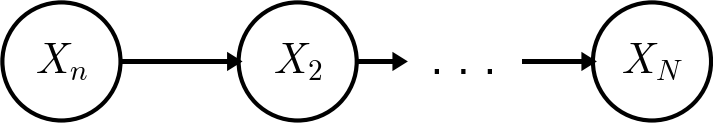

In [6]:
%%capture
pgm_markov_chain("images/pgm/markov-chain.png")

### Markov Models:  Joint Distribution

If a sequence has the Markov property, then the joint distribution factorizes according to
    $$
    p(x_1, \dots, x_N) = p(x_1) \prod_{n=2}^N p(x_n | x_{n-1})
    $$

### Markov Models:  Transition Matrix

Suppose $X_t \in \{1,\dots,K\}$ is discrete.  Then, a stationary chain with $N$ states can be described by a **transition matrix**, $A \in \R^{N \times N}$ where
    $$
    a_{ij} = p(X_t=j \mid X_{t-1}=i)
    $$

is the probability of transitioning from state $i$ to $j$.

> Each row sums to one, $\sum_{j=1}^K A_{ij} = 1$, so $A$ is a *row-stochastic matrix*.

### Markov Models:  Transition Diagram

Transitions between states can be represented as a graph:

![](./images/murphy-fig174-markov.png)

> The nodes in this graph represent states that each $X_i$ can take.

Here the transition matrix is $A = \begin{bmatrix} (1-\alpha) & \alpha  \\  \beta & (1-\beta) \end{bmatrix}$



## Why do we care about Markov Models?

**Answer**: they are the ideal model to reason about many randomized algorithms. Consider the following alg:

```python
state = 0
for i in range(NUMITER):
    cointoss = np.random.somedist() # sample a random variable
    state = update(state,cointoss)  # update state based on random sample
return state
```

We can analyze the behavior of this algorithm by viewing the `state` variable as following a markov process.



### Markov Models:  State Vectors

Consider a row vector $x_t \in \R^{1 \times K}$ with entries $x_{tj} = p(X_t = j)$.  Then,

$$
    \begin{align}
    p(X_t = j)
    &= \sum_{i=1}^K p(X_t = j \mid X_{t-1} = i) p(X_{t-1} = i) \\
    &= \sum_{i=1}^K A_{ij} x_{t-1,i} \\
    \end{align}
$$

Therefore, we conclude $x_t = x_{t-1} A$.

(Note $\sum_{j=1}^K x_{tj} = 1$.)

### Markov Models:  Matrix Powers

Since $x_t = x_{t-1} A$, this suggests that in general,
    $$
    x_{t} = x_{t-1} A = x_{t-2} A^2 = \cdots x_{0} A^t
    $$
If we know the initial state probabilities $x_0$, we can find the probabilities of landing in any state at time $t > 0$.

### Example:  Weather

Suppose the weather is either $R=\text{Rainy}$ or $S=\text{Sunny}$,
    $$
    A = \begin{bmatrix}
        0.9 & 0.1 \\
        0.5 & 0.5
    \end{bmatrix}
    $$

![](images/markov-chain-weather.png)

### Example:  Weather

Suppose today is sunny, $x_0 = \begin{bmatrix} 1 & 0 \end{bmatrix}$.  We can predict tomorrow's weather,
    $$
    x_1 = x_0 A = \begin{bmatrix} 0.9 & 0.1 \end{bmatrix}
    $$
The weather over the next several days will be
    $$
    \begin{align}
    x_2 &= x_1 A = \begin{bmatrix} 0.86 & 0.14 \end{bmatrix} \\
    x_3 &= x_2 A = \begin{bmatrix} 0.844 & 0.156 \end{bmatrix} \\
    x_4 &= x_3 A = \begin{bmatrix} 0.8376 & 0.1624 \end{bmatrix}
    \end{align}
    $$

> **Question:** What happens to $x_0 A^n$ as $n \rightarrow \infty$?

### Markov Chains:  Stationary Distribution

If we ever reach a stage $x$ where
    $$
    x = xA
    $$
then we have reached the **stationary distribution** of the chain.
- To find $x=v^T$, solve the eigenvalue problem $A^T v = v$
- Under certain conditions, the limiting distribution $\lim_{n \rightarrow \infty} x_0 A^n = x$
- Stationary distribution $x$ does not depend on the starting state $x_0$